In [305]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset,DataLoader

import matplotlib.pyplot as plt
from glob import glob as glob_module
import os
import sys

import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import random

from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ichigo7\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [306]:
# Define paths
notebook_folder = "notebooks"
data_folder = r"data\processed\imdb_data"

# Get current working directory
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, os.pardir))

# Combine paths
notebook_path = os.path.join(parent_directory, notebook_folder)
data_path = os.path.join(parent_directory, data_folder)

In [307]:
train_pos_path = os.path.join(data_path, r"train\pos")
train_neg_path = os.path.join(data_path, r"train\neg")
test_pos_path = os.path.join(data_path, r"test\pos")
test_neg_path = os.path.join(data_path, r"test\neg")

In [308]:
train_pos_files = glob_module(os.path.join(train_pos_path, '*.txt'), recursive=True)
train_neg_files = glob_module(os.path.join(train_neg_path, '*.txt'), recursive=True)
test_pos_files = glob_module(os.path.join(test_pos_path, '*.txt'), recursive=True)
test_neg_files = glob_module(os.path.join(test_neg_path, '*.txt'), recursive=True)

In [309]:
def preprocess_files(files):
    processed_files = []
    stemmer = SnowballStemmer(language="english")
    stop_words = set(stopwords.words("english"))
    for file in files:
        with open(file, "r") as f:
            text = f.read().lower()  
            
            words = re.findall(r'\b\w+\b', text)
            
            words = [stemmer.stem(word) for word in words if word not in stop_words]
            processed_files.append(words)
    return processed_files

In [310]:
pos_train = preprocess_files(train_pos_files)
neg_train = preprocess_files(train_neg_files)
pos_test = preprocess_files(test_pos_files)
neg_test = preprocess_files(test_neg_files)


In [311]:
len(pos_train)

12500

In [312]:
pos_train_label = list(np.ones(len(pos_train)))
neg_train_label = list(np.zeros(len(neg_train)))
pos_test_label = list(np.ones(len(pos_test)))
neg_test_label = list(np.zeros(len(neg_test)))

In [313]:
all_text = pos_train + neg_train + pos_test + neg_test

all_words = [word for doc in all_text for word in doc]

word_counts = Counter(all_words)

top_words = word_counts.most_common(10000)

word2id = {word: idx for idx, (word, _) in enumerate(top_words)}

id2word = {idx: word for word, idx in word2id.items()}

In [314]:
combined_data_train = list(zip(pos_train + neg_train, pos_train_label + neg_train_label))
combined_data_test = list(zip(pos_test + neg_test, pos_test_label + neg_test_label))


random.shuffle(combined_data_train)
random.shuffle(combined_data_test)


train_data, train_labels = zip(*combined_data_train)
test_data, test_labels = zip(*combined_data_test)

In [315]:
train_data[0]

['watch',
 'david',
 'bathsheba',
 'much',
 'better',
 'way',
 'get',
 'bibl',
 'lesson',
 'go',
 'sunday',
 'school',
 'despit',
 'script',
 'time',
 'unintent',
 'funni',
 'film',
 'high',
 'entertain',
 'studio',
 'system',
 'fault',
 'spare',
 'expens',
 'lavish',
 'product',
 'call',
 'peck',
 'portray',
 'king',
 'david',
 'lusti',
 'torment',
 'poet',
 'commit',
 'tantamount',
 'murder',
 'bed',
 'sexi',
 'bathsheba',
 'susan',
 'hayward',
 'raymond',
 'massey',
 'prophet',
 'nathan',
 'deliv',
 'usual',
 'saturnin',
 'feroci',
 'perform',
 'look',
 'silent',
 'screen',
 'star',
 'franci',
 'x',
 'bushman',
 'king',
 'saul',
 'young',
 'gwen',
 'verdon',
 'dancer',
 'hooray',
 'old',
 'testament',
 'hollywood']

In [316]:
UNK_TOKEN = "<UNK>"
word2id[UNK_TOKEN] = len(word2id)
for doc in train_data:
    for i, word in enumerate(doc):
        doc[i] = word2id.get(word, word2id[UNK_TOKEN])
for doc in test_data:
    for i, word in enumerate(doc):
        doc[i] = word2id.get(word, word2id[UNK_TOKEN])

unknown = word2id[UNK_TOKEN]

In [317]:
vocab_size = len(word2id)
vocab_size

10001

In [318]:
len(train_data[5])

78

In [319]:
train_data[5]

[1,
 236,
 111,
 601,
 149,
 8198,
 2882,
 5193,
 1825,
 143,
 1122,
 158,
 29,
 189,
 10,
 9,
 33,
 4,
 0,
 0,
 765,
 18,
 380,
 2,
 1286,
 654,
 4658,
 1749,
 11,
 87,
 287,
 48,
 282,
 153,
 708,
 226,
 2193,
 1140,
 627,
 1849,
 554,
 654,
 11,
 282,
 26,
 11,
 87,
 287,
 63,
 2,
 287,
 19,
 2117,
 240,
 15,
 101,
 199,
 477,
 1031,
 71,
 4526,
 2175,
 0,
 0,
 35,
 180,
 2994,
 210,
 87,
 287,
 658,
 786,
 145,
 1,
 235,
 69,
 291,
 5]

In [320]:
max_len_combined = 0
for doc in train_data + test_data:
    max_len_combined = max(max_len_combined, len(doc))
    
print("\n max length: ", max_len_combined)


 max length:  1455


In [321]:
max_len = 800

train_data = [seq for seq in train_data if seq is not None]
test_data = [seq for seq in test_data if seq is not None]

train_data_tensor = [torch.tensor(seq) for seq in train_data]
test_data_tensor = [torch.tensor(seq) for seq in test_data]

padded_train_data_tensor = nn.utils.rnn.pad_sequence(train_data_tensor, batch_first=True, padding_value=0)
padded_test_data_tensor = nn.utils.rnn.pad_sequence(test_data_tensor, batch_first=True, padding_value=0)

padded_train_data_tensor = padded_train_data_tensor[:, :max_len]
padded_test_data_tensor = padded_test_data_tensor[:, :max_len]

In [322]:
padded_train_data_tensor.shape

torch.Size([25000, 800])

In [323]:
train_labels_tensor = torch.tensor(train_labels).float()
test_labels_tensor = torch.tensor(test_labels).float()

In [324]:
train_labels_tensor[5]

tensor(0.)

In [325]:
type(padded_train_data_tensor)

torch.Tensor

In [326]:
train_set = TensorDataset(padded_train_data_tensor,train_labels_tensor)
test_set = TensorDataset(padded_test_data_tensor,test_labels_tensor)

In [327]:
train_set[0]

(tensor([   11,   529, 10000,    21,    56,    32,    10,  2766,  1261,    26,
          2349,   303,   409,   126,     5,  1949,    73,     2,   120,   167,
           803,  1289,  1452,  2388,  2133,  4793,   212,   157,  4511,   297,
           609,   529, 10000,  3399,  4927,  1028, 10000,   260,  1088,  1136,
         10000,  2358,  9650,  3978,  7004,  5635,  5315,   537,   288, 10000,
          9402,    60,    18,  1095,   165,    81,  3317,  1507, 10000,   609,
         10000,   112, 10000, 10000,  1962, 10000,    72,  3962,   302,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [328]:
batch_size = 64
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True, drop_last = True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle=True, drop_last = True)

In [329]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [330]:
class sent_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 50)
        self.lstm = nn.LSTM(50, 100, bidirectional=True, batch_first=True)
        self.bn_lstm = nn.BatchNorm1d(100 * 2) 
        self.fc1 = nn.Linear(100 * 2, 64)  
        self.bn_fc1 = nn.BatchNorm1d(64)  
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = lstm_out.transpose(1, 2) 
        lstm_out = self.bn_lstm(lstm_out)
        lstm_out = lstm_out.transpose(1, 2)  
        lstm_out = torch.max(lstm_out, dim=1)[0]  
        out = F.relu(self.fc1(lstm_out))
        out = self.bn_fc1(out)
        out = self.fc2(out)
        return out.squeeze(1)

In [331]:
def train_model(model,epochs=10):
    
    
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.00005)
    
    
    losses = []
    trainbatchloss, trainbatchAcc = [], []
    trainAcc = []
    
    testbatchAcc = []
    testAcc  = []
    
    for i in range(epochs):
        sys.stdout.write(f"\n epoch {i+1}/{epochs}")
        model.train()
        for X,y in train_loader:
            X = X.to(device)
            y = y.to(device)
            yhat = model(X)
            loss = lossfun(y,yhat)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            trainbatchloss.append(loss.item())
            trainbatchAcc.append( 100*torch.mean(((yhat>0) == y).float()).item() )
            
        
        trainAcc.append( np.mean(trainbatchAcc) )

        
        losses.append(np.mean(trainbatchloss) )
        
        model.eval()
        for Xtest,ytest in test_loader:
    
            Xtest = Xtest.to(device)
            ytest = ytest.to(device)
    
            with torch.no_grad():
                ypred = model(Xtest)
    
            testbatchAcc.append(100*torch.mean(((ypred>0) == ytest).float()).item())
        testAcc.append(np.mean(testbatchAcc))
        
    return trainAcc,testAcc,losses
        
    
    

In [332]:
modeltest = sent_model()
modeltest.to(device)
xcheck = torch.randint(0, vocab_size, (10, 500), device=device)
ycheck = modeltest(xcheck)
print(ycheck.shape)

torch.Size([10])


In [333]:
torch.cuda.empty_cache()

In [334]:
sentimentmodel = sent_model()
sentimentmodel.to(device)
trainAcc,testAcc,losses = train_model(sentimentmodel,100)


 epoch 1/100
 epoch 2/100
 epoch 3/100
 epoch 4/100
 epoch 5/100
 epoch 6/100
 epoch 7/100
 epoch 8/100
 epoch 9/100
 epoch 10/100
 epoch 11/100
 epoch 12/100
 epoch 13/100
 epoch 14/100
 epoch 15/100
 epoch 16/100
 epoch 17/100
 epoch 18/100
 epoch 19/100
 epoch 20/100
 epoch 21/100
 epoch 22/100
 epoch 23/100
 epoch 24/100
 epoch 25/100
 epoch 26/100
 epoch 27/100
 epoch 28/100
 epoch 29/100
 epoch 30/100
 epoch 31/100
 epoch 32/100
 epoch 33/100
 epoch 34/100
 epoch 35/100
 epoch 36/100
 epoch 37/100
 epoch 38/100
 epoch 39/100
 epoch 40/100
 epoch 41/100
 epoch 42/100
 epoch 43/100
 epoch 44/100
 epoch 45/100
 epoch 46/100
 epoch 47/100
 epoch 48/100
 epoch 49/100
 epoch 50/100
 epoch 51/100
 epoch 52/100
 epoch 53/100
 epoch 54/100
 epoch 55/100
 epoch 56/100
 epoch 57/100
 epoch 58/100
 epoch 59/100
 epoch 60/100
 epoch 61/100
 epoch 62/100
 epoch 63/100
 epoch 64/100
 epoch 65/100
 epoch 66/100
 epoch 67/100
 epoch 68/100
 epoch 69/100
 epoch 70/100
 epoch 71/100
 epoch 72/100


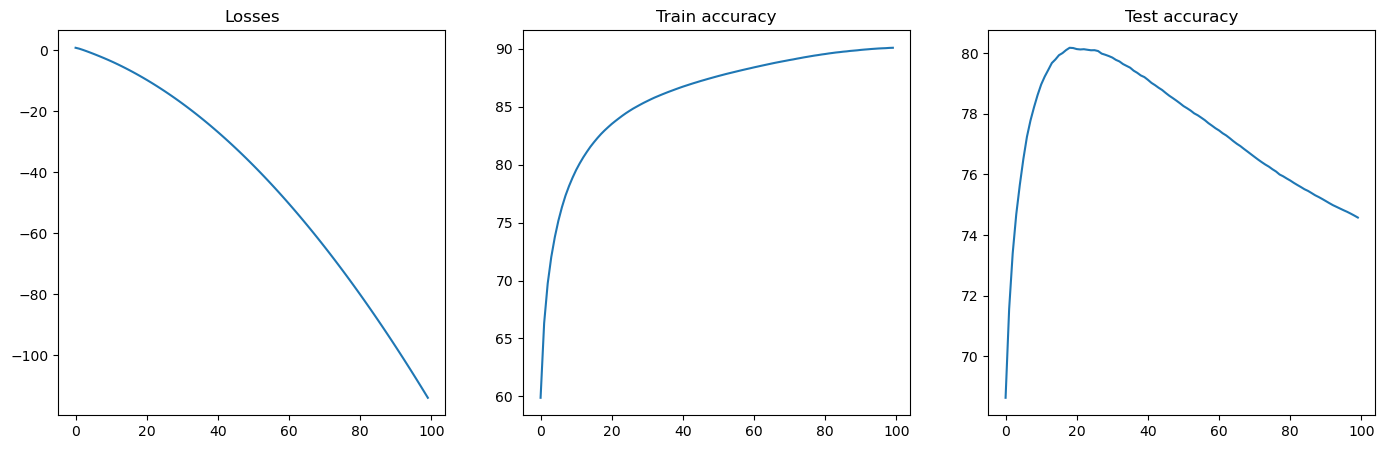

In [335]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(losses)

ax[0].set_title('Losses')


ax[1].plot(trainAcc)

ax[1].set_title('Train accuracy')


ax[2].plot(testAcc)

ax[2].set_title('Test accuracy')


plt.show()